In [1]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import warnings
from sqlalchemy import create_engine
import seaborn as sns
import scipy
import datetime

warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook

from itertools import product

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [4]:
def optimizeSARIMA(data,parameters_list, d):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [5]:
def plotSARIMA(series, model, n_steps, alpha=0.1):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:1] = np.NaN
    
    # forecasting on n_steps forward 
    #forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    #forecast = data.arima_model.append(forecast)
    forecast = best_model.get_forecast(n_steps)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast.predicted_mean, color='r', label="forecast")
    
    upper_interval = forecast.conf_int(alpha=alpha)['upper retention']
    lower_interval = forecast.conf_int(alpha=alpha)['lower retention']
    
    plt.plot(upper_interval, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(lower_interval, "r--", alpha=0.5)
    plt.fill_between(x=range(data.shape[0],data.shape[0]+n_steps), y1=upper_interval, 
                     y2=lower_interval, alpha=0.2, color = "grey") 

    #plt.axvspan(data.index[-1], forecast.predicted_mean.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.arima_model, label='fitted_values', color='r')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [3]:
retention_data = pd.read_feather('retention')

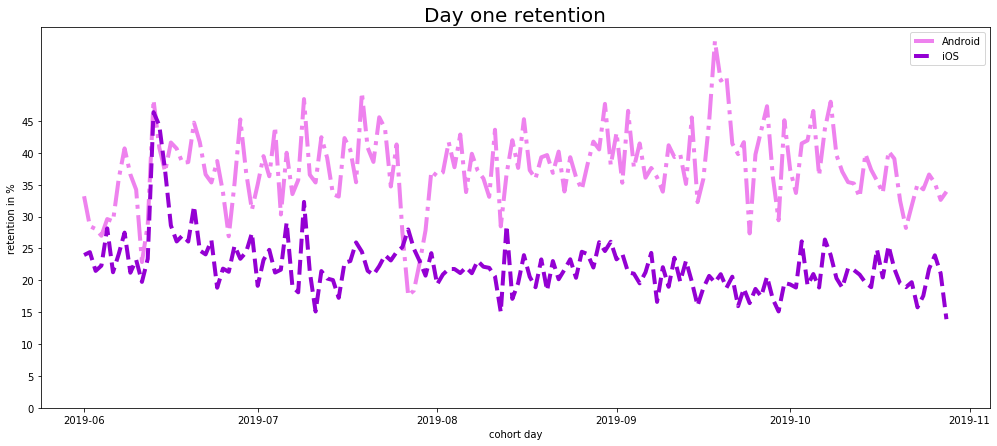

In [4]:
plt.figure(figsize=(17,7))
plt.plot(retention_data[(retention_data.funnel_day == 1) & (retention_data.platform == 'Android')].start_date,
    retention_data[(retention_data.funnel_day == 1) & (retention_data.platform == 'Android')].retention, lw =4, 
         color = 'violet', label = 'Android', ls = '-.')
plt.plot(retention_data[(retention_data.funnel_day == 1) & (retention_data.platform == 'iOS')].start_date,
    retention_data[(retention_data.funnel_day == 1) & (retention_data.platform == 'iOS')].retention, lw =4, 
         color = 'darkviolet', label = 'iOS', ls = '--')
plt.title('Day one retention', size = 20)
plt.yticks(np.arange(0,50,5))
plt.xlabel('cohort day')
plt.ylabel('retention in %')
plt.legend();

#### forecast retention Android

In [13]:
android_retention = retention_data[(retention_data.funnel_day == 1) & (retention_data.platform == 'Android')].retention

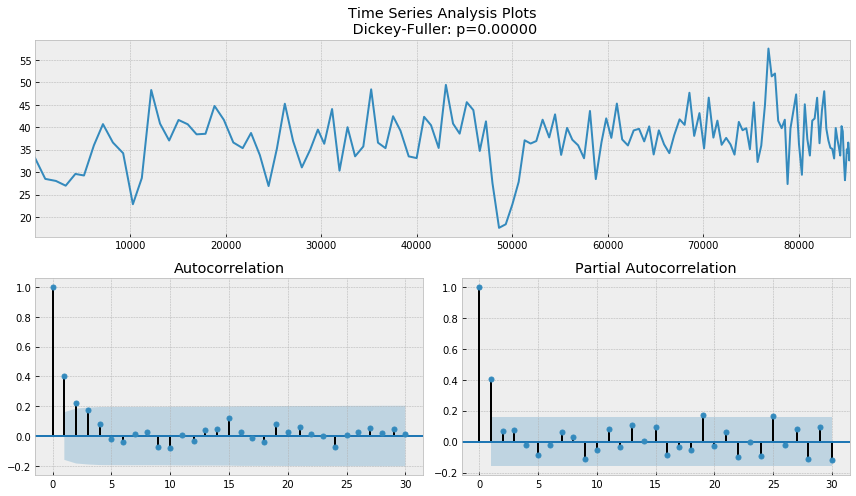

In [14]:
tsplot(android_retention, 30)

#### AR-1 MA-2

In [11]:
# setting initial values and some bounds for them
ps = range(0, 3)
d=0 
qs = range(0, 4)
Ps = 0
D=0 
Qs = 0
s = 0 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [15]:
result_table = optimizeSARIMA(android_retention, parameters_list, 0)

In [16]:
result_table

,parameters,aic
0,"(2, 2)",958.506667
1,"(1, 2)",960.282997
2,"(2, 3)",960.423524
3,"(1, 3)",960.875914
4,"(1, 1)",966.889216
5,"(2, 0)",983.616887
6,"(1, 0)",1000.742598
7,"(0, 3)",1199.570147
8,"(0, 2)",1259.862123
9,"(0, 1)",1355.853908


In [39]:
best_model=sm.tsa.statespace.SARIMAX(android_retention.reset_index(drop=True), order=(2, 0, 2)).fit(disp=-1)
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              retention   No. Observations:                  150
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -474.253
Date:                Mon, 04 Nov 2019   AIC                            958.507
Time:                        22:57:09   BIC                            973.560
Sample:                             0   HQIC                           964.622
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6007      0.208      7.705      0.000       1.193       2.008
ar.L2         -0.6007      0.208     -2.891      0.004      -1.008      -0.194
ma.L1         -1.2221      0.238     -5.137      0.0

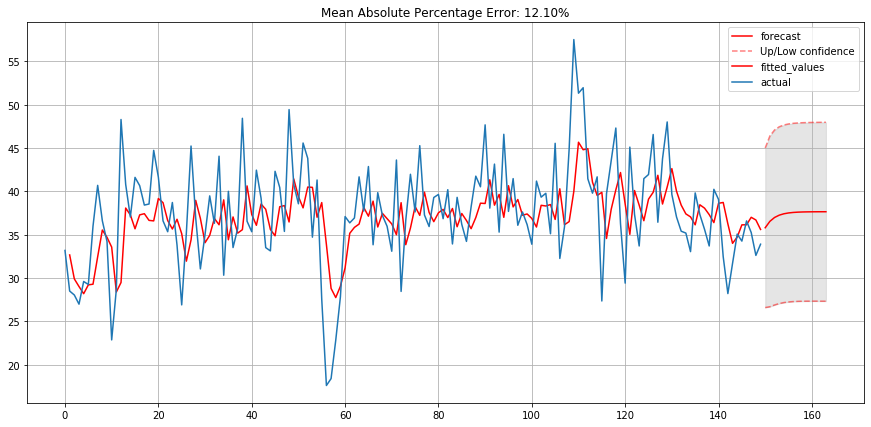

In [67]:
plotSARIMA(pd.DataFrame(android_retention).reset_index(drop=True), best_model, 14)

#### forecast retention iOS

In [68]:
iOS_retention = retention_data[(retention_data.funnel_day == 1) & (retention_data.platform == 'iOS')].retention

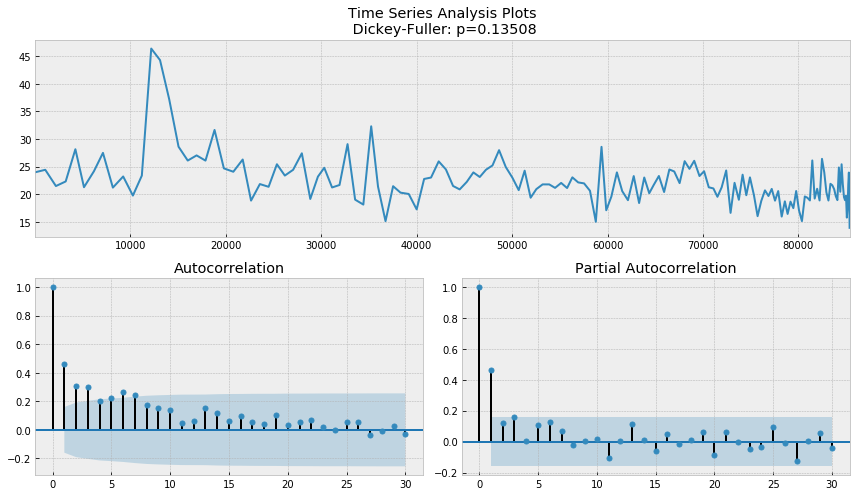

In [69]:
tsplot(iOS_retention, 30)

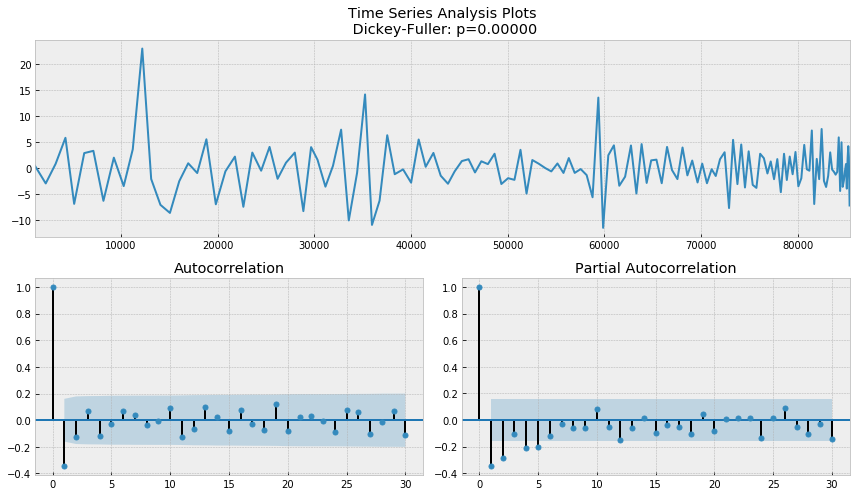

In [71]:
diff = iOS_retention - iOS_retention.shift(1)
tsplot(diff[1:], lags=30)

#### AR-5 MA-1 d=1

In [74]:
# setting initial values and some bounds for them
ps = range(0, 6)
d=1 
qs = range(0, 2)

# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [75]:
result_table = optimizeSARIMA(iOS_retention, parameters_list, d)

In [76]:
result_table

,parameters,aic
0,"(1, 1)",828.757052
1,"(2, 1)",830.624952
2,"(3, 1)",831.635421
3,"(4, 1)",833.107266
4,"(5, 1)",834.572532
5,"(0, 1)",834.836561
6,"(5, 0)",838.226788
7,"(4, 0)",842.058797
8,"(2, 0)",845.946952
9,"(3, 0)",846.158980


In [77]:
best_model=sm.tsa.statespace.SARIMAX(iOS_retention.reset_index(drop=True), order=(1, 1, 1)).fit(disp=-1)

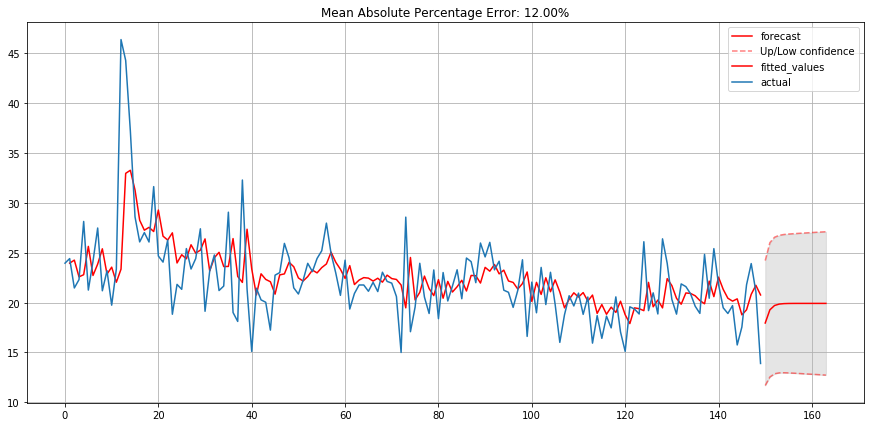

In [78]:
plotSARIMA(pd.DataFrame(iOS_retention).reset_index(drop=True), best_model, 14)

### Retention Android day 1

In [6]:
df = pd.read_csv('/Users/juliap/Desktop/Work/retention_df.csv')

In [7]:
def GetXY(platform, startdate, day):
    """platform - insert platform as it is in database
       startdate - 'yyyy-mm-dd'
       day - retention date
    """
    my_date = startdate.split('-')
    y = retention_df[(retention_df.platform == platform)&
                     (retention_df.retention_day == day)&
                     (retention_df.start_date > datetime.datetime(int(my_date[0]), 
                                                                  int(my_date[1]),
                                                                  int(my_date[2])))]['retention'].values
    
    x = retention_df[(retention_df.platform == platform)&
                     (retention_df.retention_day == day) &
                     (retention_df.start_date > datetime.datetime(int(my_date[0]), 
                                                                  int(my_date[1]),
                                                                  int(my_date[2])))]['start_date'].values
    x = pd.to_datetime(x).strftime('%Y-%m-%d').values
    return x,y

In [8]:
df.dropna(inplace=True)

In [9]:
android_df = df[df.platform == "Android"]

In [10]:
android_df[['start_date_datetime']] = android_df[['start_date']].apply(pd.to_datetime)

In [11]:
android_df.sort_values(by='start_date_datetime', inplace=True)

In [12]:
def DfSlicing():
    df = android_df[((android_df.start_date_datetime <= datetime.datetime(2019, 11, 15)) & 
                (android_df.start_date_datetime >= datetime.datetime(2019, 8, 1)) &
                (android_df.retention_day == 1))]
    df.drop('Unnamed: 0', axis=1,inplace=True)
    return df

In [13]:
android_df_1 = DfSlicing()

In [14]:
android_df_1.head(2)

,platform,retention_day,start_date,cohort,reteined_users,retention,start_date_datetime
1077,Android,1,2019-08-01,132.0,48,36.363636,2019-08-01
1078,Android,1,2019-08-02,130.0,48,36.923077,2019-08-02


### Forcasting

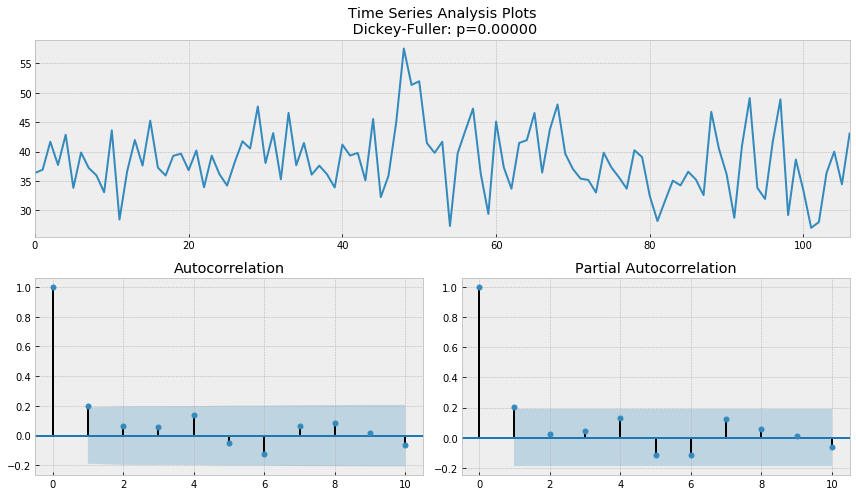

In [15]:
tsplot(android_df_1.retention.values, 10)

In [16]:
# AR - 0-1 MA 0-1
# setting initial values and some bounds for them
ps = range(0, 2)
d=0 
qs = range(0, 2)
s = 0
# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [17]:
result_table = optimizeSARIMA(android_df_1.retention.values, parameters_list, d)

In [18]:
result_table

,parameters,aic
0,"(1, 1)",682.850429
1,"(1, 0)",727.643807
2,"(0, 1)",975.388684
3,"(0, 0)",1088.725704


In [19]:
best_model=sm.tsa.statespace.SARIMAX(android_df_1.retention.reset_index(drop=True), order=(1, 0, 1)).fit(disp=-1)
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              retention   No. Observations:                  107
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -338.425
Date:                Tue, 17 Dec 2019   AIC                            682.850
Time:                        13:06:13   BIC                            690.869
Sample:                             0   HQIC                           686.101
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.001   1401.416      0.000       0.999       1.001
ma.L1         -0.9203      0.039    -23.708      0.000      -0.996      -0.844
sigma2        31.0209      3.838      8.082      0.0

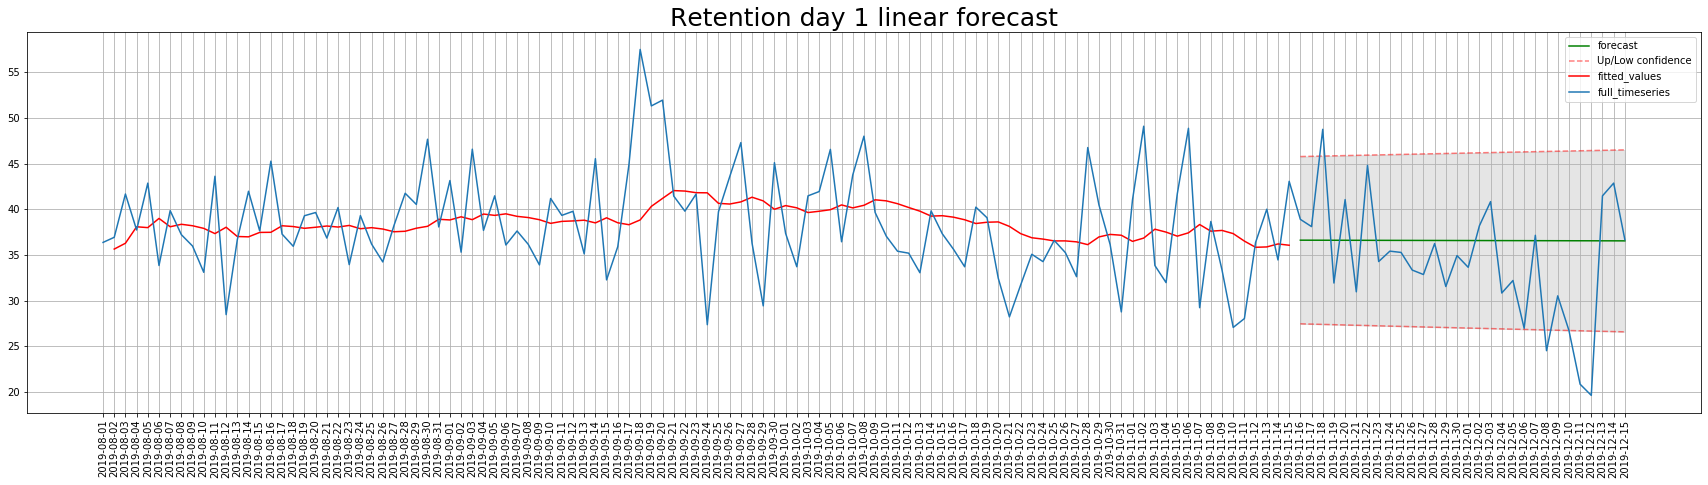

In [29]:
#plotSARIMA(pd.DataFrame(android_df_1.retention).reset_index(drop=True), best_model, 30)


series = pd.DataFrame(android_df_1.retention).reset_index(drop=True)
model = best_model
n_steps = 30 
alpha = 0.1

full_timeseries = android_df[((android_df.retention_day == 1) & 
                              (android_df.start_date_datetime >= datetime.datetime(2019, 8, 1)) & 
                              (android_df.start_date_datetime <= datetime.datetime(2019, 12, 15)))]['retention'].values
dates = android_df[((android_df.retention_day == 1) & 
                              (android_df.start_date_datetime >= datetime.datetime(2019, 8, 1)) & 
                              (android_df.start_date_datetime <= datetime.datetime(2019, 12, 15)))]['start_date'].values
# adding model values
data = series.copy()
data.columns = ['actual']
data['arima_model'] = model.fittedvalues
# making a shift on s+d steps, because these values were unobserved by the model
# due to the differentiating
data['arima_model'][:1] = np.NaN

# forecasting on n_steps forward 
#forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
#forecast = data.arima_model.append(forecast)
forecast = best_model.get_forecast(n_steps)
# calculate error, again having shifted on s+d steps from the beginning
error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

plt.figure(figsize=(30, 7))
plt.title("Retention day 1 linear forecast",fontsize = 25)
plt.plot(forecast.predicted_mean, color='g', label="forecast")

upper_interval = forecast.conf_int(alpha=alpha)['upper retention']
lower_interval = forecast.conf_int(alpha=alpha)['lower retention']

plt.plot(upper_interval, "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(lower_interval, "r--", alpha=0.5)
plt.fill_between(x=range(data.shape[0],data.shape[0]+n_steps), y1=upper_interval, 
                 y2=lower_interval, alpha=0.2, color = "grey") 

#plt.axvspan(data.index[-1], forecast.predicted_mean.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data.arima_model, label='fitted_values', color='r')
#plt.plot(data.actual, label="actual")
plt.plot( dates, full_timeseries, label = 'full_timeseries')
#plt.xticks( rotation=80, fontsize=7  )
plt.legend()
plt.xticks(rotation = 90)
plt.grid(True);

### Forecast of some average metrics 

In [125]:
average_df = pd.read_csv('/Users/juliap/Desktop/Work/average_metrics.csv')
average_df.drop('Unnamed: 0', axis =1, inplace=True)

In [127]:
average_df['date_datetime'] = average_df.date.apply(pd.to_datetime)

In [129]:
average_df.sort_values('date_datetime',inplace=True)

In [ ]:
average_df_sliced = average_df[]

In [148]:
avg_df = average_df[((average_df.date_datetime <= datetime.datetime(2019, 11, 5)) & 
            (average_df.date_datetime >= datetime.datetime(2019, 8, 1)))]

### View time ratio Forecast

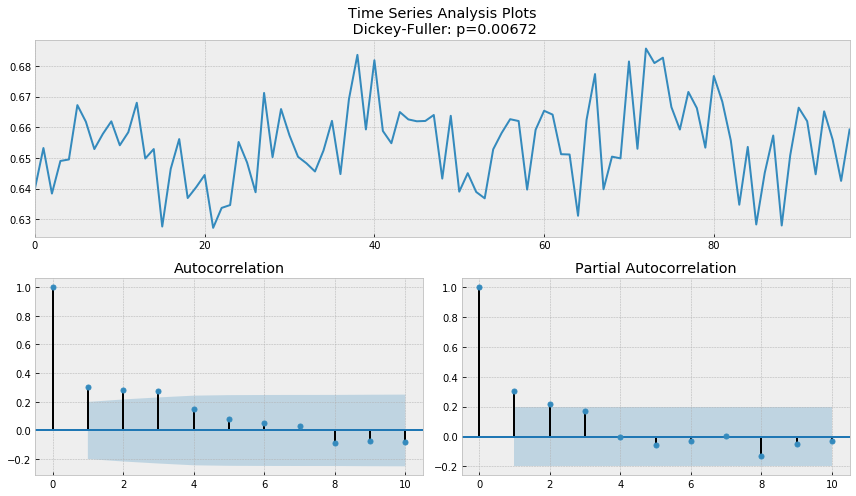

In [149]:
tsplot(avg_df.view_time_ratio.values, 10)

In [150]:
# AR - 0-3 MA 0-3
# setting initial values and some bounds for them
ps = range(0, 4)
d=0 
qs = range(0, 4)
s = 0
# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [151]:
result_table = optimizeSARIMA(avg_df.view_time_ratio.values, parameters_list, d)

In [152]:
result_table

,parameters,aic
0,"(1, 2)",-551.600450
1,"(2, 2)",-551.476192
2,"(3, 2)",-549.788968
3,"(2, 3)",-548.667610
4,"(1, 3)",-548.082789
5,"(3, 3)",-546.211246
6,"(2, 0)",-540.710157
7,"(0, 2)",-35.829519
8,"(0, 1)",68.940960
9,"(0, 0)",195.167599


In [153]:
best_model=sm.tsa.statespace.SARIMAX(avg_df.view_time_ratio.reset_index(drop=True), order=(1, 0, 2)).fit(disp=-1)
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:        view_time_ratio   No. Observations:                   97
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 279.800
Date:                Wed, 11 Dec 2019   AIC                           -551.600
Time:                        14:54:18   BIC                           -541.302
Sample:                             0   HQIC                          -547.436
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   3593.395      0.000       0.999       1.001
ma.L1         -0.6503      0.125     -5.193      0.000      -0.896      -0.405
ma.L2         -0.0178      0.095     -0.188      0.8

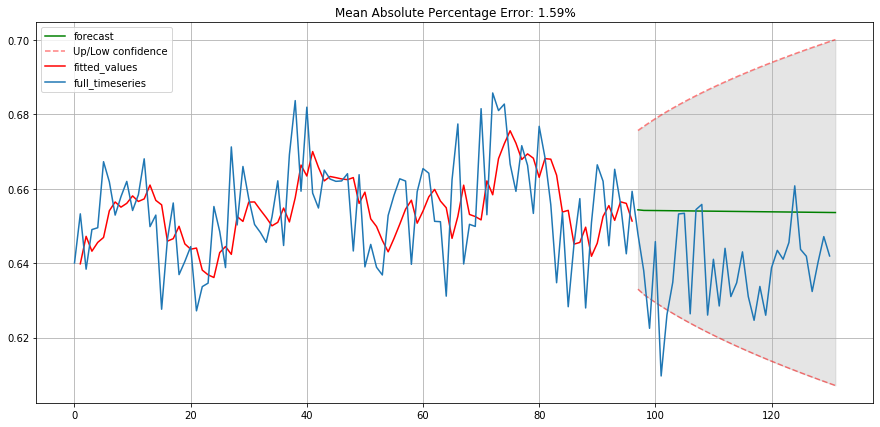

In [154]:
#plotSARIMA(pd.DataFrame(android_df_1.retention).reset_index(drop=True), best_model, 30)

series = pd.DataFrame(avg_df.view_time_ratio).reset_index(drop=True)
model = best_model
n_steps = 35 
alpha = 0.1

full_timeseries = average_df[((average_df.date_datetime >= datetime.datetime(2019, 8, 1)) & 
                              (average_df.date_datetime <= datetime.datetime(2019, 12, 9)))]['view_time_ratio'].values
# adding model values
data = series.copy()
data.columns = ['actual']
data['arima_model'] = model.fittedvalues
# making a shift on s+d steps, because these values were unobserved by the model
# due to the differentiating
data['arima_model'][:1] = np.NaN

# forecasting on n_steps forward 
#forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
#forecast = data.arima_model.append(forecast)
forecast = best_model.get_forecast(n_steps)
# calculate error, again having shifted on s+d steps from the beginning
error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

plt.figure(figsize=(15, 7))
plt.title("% of time in the app users spent watching videos")
plt.plot(forecast.predicted_mean, color='g', label="forecast")

upper_interval = forecast.conf_int(alpha=alpha)['upper view_time_ratio']
lower_interval = forecast.conf_int(alpha=alpha)['lower view_time_ratio']

plt.plot(upper_interval, "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(lower_interval, "r--", alpha=0.5)
plt.fill_between(x=range(data.shape[0],data.shape[0]+n_steps), y1=upper_interval, 
                 y2=lower_interval, alpha=0.2, color = "grey") 

#plt.axvspan(data.index[-1], forecast.predicted_mean.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data.arima_model, label='fitted_values', color='r')
#plt.plot(data.actual, label="actual")
plt.plot(  full_timeseries, label = 'full_timeseries')
#plt.xticks( rotation=80, fontsize=7  )
plt.legend()
plt.grid(True);

## Activity new users vs. old

In [155]:
df = pd.read_csv('../Work/channel_sessions_days_active.csv')

In [158]:
old_users = df[df.days_in_app >= 7]
new_users = df[df.days_in_app < 7]

In [175]:
old_users.head(2)

,Unnamed: 0,client_id,date,session_duration,video_count_3sec,video_count_finished,video_count_nonzero,view_time,finished_ratio,3_sec_ratio,view_time_ratio,first_seen,date_datetime,first_seen_str,first_seen_datetime,days_in_app
6,6,0003071b8d9a0c7a,2019-11-11,1537,33,8,37,1345,0.216216,0.891892,0.875081,2019-11-04 21:55:55.582000+00:00,2019-11-11,2019-11-04,2019-11-04,7
10,10,000e7546d79b9c8b,2019-09-08,1036,54,39,60,762,0.650000,0.900000,0.735521,2019-09-01 17:46:34.700000+00:00,2019-09-08,2019-09-01,2019-09-01,7


In [177]:
def PivotMean(data, values, func):
    df = pd.pivot_table(data, index = ['date'], values = values, aggfunc=func)
    return df

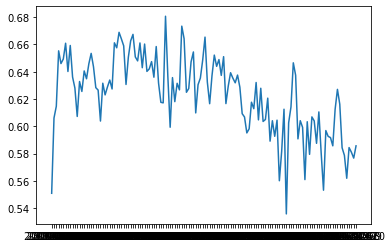

In [183]:
plt.plot(PivotMean(new_users,['view_time_ratio'],'mean'));

In [176]:
pd.pivot_table(old_users, index = ['date'], values = ['view_time_ratio'], aggfunc='mean')

,view_time_ratio
date,
2019-08-08,0.739429
2019-08-09,0.745083
2019-08-10,0.664784
2019-08-11,0.734211
2019-08-12,0.780981
...,...
2019-12-06,0.684361
2019-12-07,0.711269
2019-12-08,0.691807
